In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lightgbm import LGBMRegressor, LGBMRanker
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterSampler, GroupKFold
from sklearn.metrics import ndcg_score
import pickle
import warnings
import os

In [ ]:
rating = pd.read_csv('../data/tourism_rating.csv')
id_tourism = pd.read_csv('../data/tourism_with_id.csv')
users = pd.read_csv('../data/user.csv')

In [7]:
print(f'Isi dari Rating dataset: {rating.info()}')
print(f'\nIsi dari Tourism ID:\n {id_tourism.info()}')
print(f'\nIsi dari user dataset:\n {users.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB
Isi dari Rating dataset: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    

In [8]:
id_tourism.Category.unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [9]:
id_tourism.City.unique()

array(['Jakarta', 'Yogyakarta', 'Bandung', 'Semarang', 'Surabaya'],
      dtype=object)

In [10]:
rating.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

In [11]:
print(id_tourism.isnull().sum())
print(users.isnull().sum())

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64
User_Id     0
Location    0
Age         0
dtype: int64


In [12]:
rating.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


In [13]:
users.describe()

,User_Id,Age
count,300.000000,300.000000
mean,150.500000,28.700000
std,86.746758,6.393716
min,1.000000,18.000000
25%,75.750000,24.000000
50%,150.500000,29.000000
75%,225.250000,34.000000
max,300.000000,40.000000


In [14]:
id_tourism.describe()

,Place_Id,Price,Rating,Time_Minutes,Lat,Long,Unnamed: 11,Unnamed: 12
count,437.000000,437.000000,437.000000,205.000000,437.000000,437.000000,0.0,437.000000
mean,219.000000,24652.173913,4.442792,82.609756,-7.095438,109.160142,NaN,219.000000
std,126.295289,66446.374709,0.208587,52.872339,0.727241,1.962848,NaN,126.295289
min,1.000000,0.000000,3.400000,10.000000,-8.197894,103.931398,NaN,1.000000
25%,110.000000,0.000000,4.300000,45.000000,-7.749590,107.578369,NaN,110.000000
50%,219.000000,5000.000000,4.500000,60.000000,-7.020524,110.237468,NaN,219.000000
75%,328.000000,20000.000000,4.600000,120.000000,-6.829411,110.431869,NaN,328.000000
max,437.000000,900000.000000,5.000000,360.000000,1.078880,112.821662,NaN,437.000000


Visualisasi

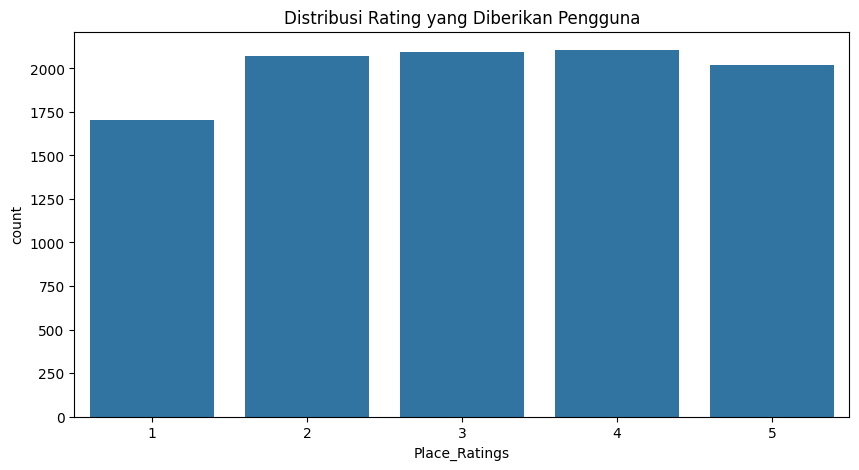

In [15]:
# Distribusi Rating yang Diberikan Pengguna
plt.figure(figsize=(10, 5))
sns.countplot(x=rating['Place_Ratings']) # Corrected column name
plt.title('Distribusi Rating yang Diberikan Pengguna')
plt.show()

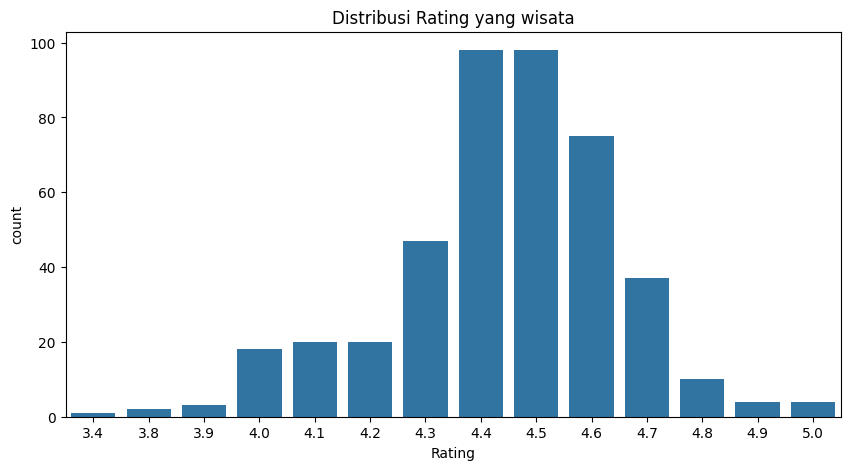

In [16]:
# Distribusi Rating yang wisata
plt.figure(figsize=(10, 5))
sns.countplot(x=id_tourism['Rating']) # Corrected column name
plt.title('Distribusi Rating yang wisata')
plt.show()

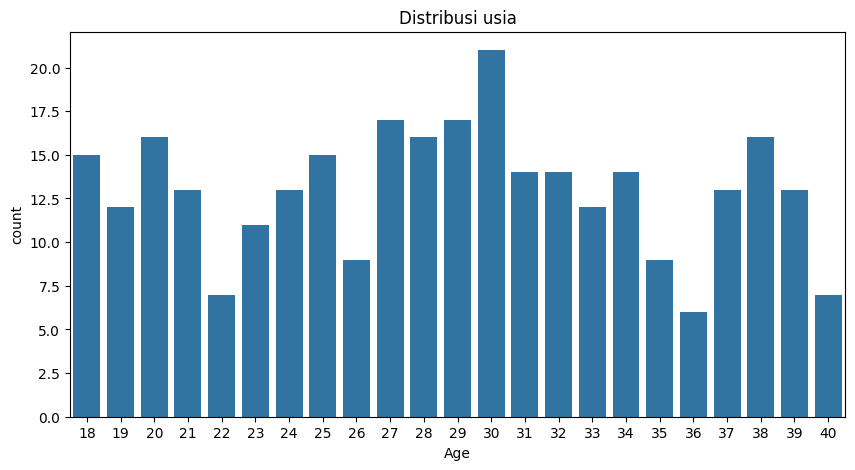

In [17]:
# Distribusi umur
plt.figure(figsize=(10, 5))
sns.countplot(x=users['Age']) # Corrected column name
plt.title('Distribusi usia')
plt.show()

In [18]:
id_tourism.head()


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [19]:
places = id_tourism[['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating']]
places.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5


In [20]:
users.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [21]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


Feature Engineering

In [22]:
price_bins = [-1, 25000, 100000, np.inf]
price_labels = ['murah', 'menengah', 'mahal']
places['price_category'] = pd.cut(places['Price'], bins=price_bins, labels=price_labels)

# --- TAMBAHAN: Verifikasi Hasil Binning ---
print("\n✅ Verifikasi hasil binning harga:")
print(places[['Place_Name', 'Price', 'price_category']].head(10))
print("\n")


✅ Verifikasi hasil binning harga:
                          Place_Name   Price price_category
0                   Monumen Nasional   20000          murah
1                           Kota Tua       0          murah
2                      Dunia Fantasi  270000          mahal
3  Taman Mini Indonesia Indah (TMII)   10000          murah
4           Atlantis Water Adventure   94000       menengah
5            Taman Impian Jaya Ancol   25000          murah
6             Kebun Binatang Ragunan    4000          murah
7                      Ocean Ecopark  180000          mahal
8                   Pelabuhan Marina  175000          mahal
9                       Pulau Tidung  150000          mahal




/tmp/ipykernel_2374/306976052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  places['price_category'] = pd.cut(places['Price'], bins=price_bins, labels=price_labels)


In [23]:
places.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,price_category
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,murah
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,murah
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,mahal
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,murah
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,menengah


In [24]:
encoders = {}
for col in ['Category', 'City']:
    places[f'{col}_name'] = places[col]
    le = LabelEncoder()
    places[col] = le.fit_transform(places[col].astype(str))
    encoders[col] = le

/tmp/ipykernel_2374/511997963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  places[f'{col}_name'] = places[col]
/tmp/ipykernel_2374/511997963.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  places[col] = le.fit_transform(places[col].astype(str))
/tmp/ipykernel_2374/511997963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [25]:
df = rating.merge(users, on="User_Id").merge(places, on="Place_Id")
print("✅ Data berhasil digabungkan. DataFrame 'df' sekarang berisi semua fitur.")

✅ Data berhasil digabungkan. DataFrame 'df' sekarang berisi semua fitur.


In [26]:
df.head()

,User_Id,Place_Id,Place_Ratings,Location,Age,Place_Name,Description,Category,City,Price,Rating,price_category,Category_name,City_name
0,1,179,3,"Semarang, Jawa Tengah",20,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,1,4,75000,4.6,menengah,Budaya,Yogyakarta
1,1,344,2,"Semarang, Jawa Tengah",20,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",0,2,3000,4.1,murah,Bahari,Semarang
2,1,5,5,"Semarang, Jawa Tengah",20,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,4,1,94000,4.5,menengah,Taman Hiburan,Jakarta
3,1,373,3,"Semarang, Jawa Tengah",20,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,1,2,10000,4.5,murah,Budaya,Semarang
4,1,101,4,"Semarang, Jawa Tengah",20,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,1,4,0,4.0,murah,Budaya,Yogyakarta


In [27]:
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(places['Description'].fillna(""))
user_profiles = {}
for u_id in df['User_Id'].unique():
    liked_places_ids = df[(df['User_Id'] == u_id) & (df['Place_Ratings'] >= 4)]['Place_Id']
    if not liked_places_ids.empty:
        liked_indices = places[places['Place_Id'].isin(liked_places_ids)].index
        user_profiles[u_id] = tfidf_matrix[liked_indices].mean(axis=0).A1
    else:
        user_profiles[u_id] = np.zeros(tfidf_matrix.shape[1])

In [28]:
content_scores_df = pd.DataFrame(cosine_similarity(list(user_profiles.values()), tfidf_matrix), index=df['User_Id'].unique(), columns=places['Place_Id'])
user_item_matrix = df.pivot_table(index="User_Id", columns="Place_Id", values="Place_Ratings").fillna(0)
user_similarity = cosine_similarity(user_item_matrix)
user_cf_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T
user_cf_scores_df = pd.DataFrame(user_cf_scores, index=user_item_matrix.index, columns=user_item_matrix.columns)
item_similarity = cosine_similarity(user_item_matrix.T)
item_cf_scores = user_item_matrix.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
item_cf_scores_df = pd.DataFrame(item_cf_scores, index=user_item_matrix.index, columns=user_item_matrix.columns)
print("✅ Feature engineering lanjutan selesai.")

✅ Feature engineering lanjutan selesai.


# --- 4. Bangun Matriks Fitur untuk LTR ---

In [29]:
places_indexed = places.set_index('Place_Id')
users_indexed = users.set_index('User_Id')

def get_age_price_interaction(age, price_category):
    """Membuat fitur interaksi antara usia dan kategori harga."""
    if age < 25 and price_category == 'mahal': return 0  # Tidak cocok
    if age > 40 and price_category == 'murah': return 0.5 # Kurang cocok
    return 1 # Cocok

def create_feature_matrix(users_list, places_list):
    feature_rows, labels, groups = [], [], []
    for u_id in users_list:
        user_given_ratings = df[df['User_Id'] == u_id].set_index('Place_Id')['Place_Ratings'].to_dict()
        user_age = users_indexed.loc[u_id, 'Age']
        groups.append(len(places_list))
        for p_id in places_list:
            labels.append(user_given_ratings.get(p_id, 0))
            place_features = places_indexed.loc[p_id]

            # FITUR INTERAKSI BARU
            age_price_feature = get_age_price_interaction(user_age, place_features['price_category'])

            features = [
                content_scores_df.loc[u_id, p_id], user_cf_scores_df.loc[u_id, p_id],
                item_cf_scores_df.loc[u_id, p_id], user_age,
                place_features['Rating'], place_features['Price'],
                place_features['Category'], place_features['City'],
                age_price_feature # Menambahkan fitur interaksi
            ]
            feature_rows.append(features)
    return np.array(feature_rows), np.array(labels), np.array(groups)

# --- 5. Hyperparameter Tuning dengan RandomizedSearchCV ---

In [30]:
print("\n--- Memulai Hyperparameter Tuning ---")
all_users = df['User_Id'].unique()
all_places = places['Place_Id'].unique()

X_full_tuning, y_full_tuning, _ = create_feature_matrix(all_users, all_places)

# Definisikan ruang parameter untuk dicari
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 5, 10, 15],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0]
}

# Gunakan ParameterSampler untuk mendapatkan kombinasi acak
param_sampler = ParameterSampler(param_dist, n_iter=10, random_state=42)

# Gunakan GroupKFold untuk memastikan user tidak terpisah antar fold
group_kfold = GroupKFold(n_splits=5)
user_ids_for_groups = np.repeat(all_users, len(all_places))

best_score = -1
best_params = {}
results = []

# Loop manual untuk random search
for params in param_sampler:
    print(f"Menguji parameter: {params}")
    fold_scores = []

    # Loop validasi silang (cross-validation)
    for train_idx, test_idx in group_kfold.split(X_full_tuning, y_full_tuning, groups=user_ids_for_groups):
        # Bagi data
        X_train, X_test = X_full_tuning[train_idx], X_full_tuning[test_idx]
        y_train, y_test = y_full_tuning[train_idx], y_full_tuning[test_idx]

        # Hitung ulang informasi grup untuk set training
        train_groups = pd.DataFrame({'user': user_ids_for_groups[train_idx]}).groupby('user').size().to_numpy()

        # Latih model
        model = LGBMRanker(objective='lambdarank', random_state=42, **params)
        model.fit(X_train, y_train, group=train_groups)

        # Prediksi pada set test
        y_pred = model.predict(X_test)

        # Evaluasi skor NDCG untuk fold ini
        test_groups = pd.DataFrame({'user': user_ids_for_groups[test_idx]}).groupby('user').size().to_numpy()

        fold_ndcg_scores = []
        current_pos = 0
        for group_size in test_groups:
            y_true_group = y_test[current_pos : current_pos + group_size].reshape(1, -1)
            y_pred_group = y_pred[current_pos : current_pos + group_size].reshape(1, -1)
            fold_ndcg_scores.append(ndcg_score(y_true_group, y_pred_group))
            current_pos += group_size

        fold_scores.append(np.mean(fold_ndcg_scores))

    avg_score = np.mean(fold_scores)
    results.append({'params': params, 'score': avg_score})
    print(f"  -> Rata-rata NDCG: {avg_score:.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = params

print("\n--- Hasil Tuning ---")
print(f"Parameter terbaik ditemukan: {best_params}")
print(f"Skor NDCG terbaik (cross-validated): {best_score:.4f}")


--- Memulai Hyperparameter Tuning ---
Menguji parameter: {'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.05}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9735
Menguji parameter: {'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9707
Menguji parameter: {'reg_lambda': 1.0, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9716
Menguji parameter: {'reg_lambda': 0.1, 'reg_alpha': 1.0, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.05}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9698
Menguji parameter: {'reg_lambda': 1.0, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9711
Menguji parameter: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 20, 'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.05}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9710
Menguji parameter: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


  -> Rata-rata NDCG: 0.9741
Menguji parameter: {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.01}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 104880, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


# --- 8. Latih Model Optimal dan Evaluasi ---

In [31]:
# Latih model final dengan parameter terbaik pada seluruh data
ltr_model_optimal = LGBMRanker(objective='lambdarank', metric='ndcg', random_state=42, **best_params)
# Kita butuh grup untuk seluruh data untuk melatih model final
_, _, group_full = create_feature_matrix(all_users, all_places)
ltr_model_optimal.fit(X_full_tuning, y_full_tuning, group=group_full)
print("\n✅ Model LTR optimal berhasil dilatih dengan parameter terbaik.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 131100, number of used features: 9

✅ Model LTR optimal berhasil dilatih dengan parameter terbaik.


# --- 9. Fungsi Rekomendasi (menggunakan model optimal) ---

In [32]:
def recommend_with_filters(user_id, user_location=None, min_rating=None, price_cat=None, category_name=None, top_n=10):
    candidate_places = places.copy()
    # Filter Lokasi
    if user_location:
        candidate_places = candidate_places[candidate_places['City_name'] == user_location]
    if min_rating is not None: candidate_places = candidate_places[candidate_places['Rating'] >= min_rating]
    if price_cat is not None: candidate_places = candidate_places[candidate_places['price_category'] == price_cat]
    if category_name is not None: candidate_places = candidate_places[candidate_places['Category_name'] == category_name]
    if candidate_places.empty: return pd.DataFrame()
    candidate_ids = candidate_places['Place_Id'].unique()
    try:
        user_id_typed = type(all_users[0])(user_id)
        user_idx = list(all_users).index(user_id_typed)
    except (ValueError, TypeError): return f"User ID '{user_id}' tidak ditemukan."
    start_idx, end_idx = user_idx * len(all_places), (user_idx + 1) * len(all_places)
    user_scores = ltr_model_optimal.predict(X_full_tuning[start_idx:end_idx])
    scores_df = pd.DataFrame({'Place_Id': all_places, 'score': user_scores})
    filtered_scores = scores_df[scores_df['Place_Id'].isin(candidate_ids)]
    rated_places = df[df['User_Id'] == user_id_typed]['Place_Id'].unique()
    final_candidates = filtered_scores[~filtered_scores['Place_Id'].isin(rated_places)]
    top_recommendations = final_candidates.sort_values('score', ascending=False).head(top_n)
    return top_recommendations.merge(places, on='Place_Id')

def recommend_for_new_user(user_location=None, min_rating=None, price_cat=None, category_name=None, top_n=10):
    candidate_places = places.copy()
    # Filter Lokasi
    if user_location:
        candidate_places = candidate_places[candidate_places['City_name'] == user_location]
    if min_rating is not None: candidate_places = candidate_places[candidate_places['Rating'] >= min_rating]
    if price_cat is not None: candidate_places = candidate_places[candidate_places['price_category'] == price_cat]
    if category_name is not None: candidate_places = candidate_places[candidate_places['Category_name'] == category_name]
    if candidate_places.empty: return pd.DataFrame()
    return candidate_places.sort_values('Rating', ascending=False).head(top_n)

In [33]:
print("\n--- Selamat Datang di Sistem Rekomendasi Wisata Interaktif ---")
while True:
    print("\nSilakan masukkan kriteria Anda (kosongkan jika tidak ingin menggunakan filter).")

    user_id_input = input("Masukkan User ID Anda (contoh: 1, 2, ...) atau ketik 'baru' atau kosongkan: ")
    location_input = input("Masukkan Lokasi Anda (Jakarta, Yogyakarta, Bandung, Semarang, Surabaya): ")
    rating_input = input("Masukkan Rating minimal (contoh: 4.5, rentang 4.0 - 5.0): ")
    price_input = input("Pilih Kategori Harga (murah/menengah/mahal): ")
    category_input = input("Masukkan Kategori Wisata (Budaya, Taman Hiburan, Cagar Alam, Bahari, Pusat Perbelanjaan, Tempat Ibadah): ")

    # Proses input
    user_location = location_input if location_input else None
    min_rating = float(rating_input) if rating_input else None
    price_cat = price_input if price_input else None
    category_name = category_input if category_input else None

    recs = None

    # Panggil fungsi yang sesuai
    # PERBAIKAN: Jika input user_id kosong atau 'baru', panggil recommend_for_new_user
    if user_id_input.lower() == 'baru' or not user_id_input:
        print("\n=> Menampilkan rekomendasi populer untuk PENGGUNA BARU...")
        recs = recommend_for_new_user(
            user_location=user_location,
            min_rating=min_rating,
            price_cat=price_cat,
            category_name=category_name
        )
    else:
        try:
            user_id = int(user_id_input)
            print(f"\n=> Menampilkan rekomendasi yang dipersonalisasi untuk PENGGUNA ID: {user_id}...")
            recs = recommend_with_filters(
                user_id=user_id,
                user_location=user_location,
                min_rating=min_rating,
                price_cat=price_cat,
                category_name=category_name
            )
        except ValueError:
            print(f"Error: User ID '{user_id_input}' tidak valid. Harap masukkan angka, 'baru', atau kosongkan.")
            recs = f"User ID '{user_id_input}' tidak ditemukan."

    # Tampilkan hasil
    print("\n--- Hasil Rekomendasi ---")
    if isinstance(recs, pd.DataFrame):
        if recs.empty:
            print("Tidak ada rekomendasi yang cocok ditemukan dengan kriteria Anda.")
        else:
            # Tampilkan kolom yang relevan
            display_cols = ['Place_Name', 'Category_name', 'City_name', 'price_category', 'Rating']
            if 'score' in recs.columns:
                display_cols.append('score')
            print(recs[display_cols].to_string(index=False))
    else:
        print(recs) # Cetak pesan error jika ada

    # Tanya untuk lanjut atau tidak
    lanjut = input("\nCoba lagi? (y/n): ")
    if lanjut.lower() != 'y':
        break

print("\nTerima kasih telah menggunakan sistem rekomendasi!")


--- Selamat Datang di Sistem Rekomendasi Wisata Interaktif ---

Silakan masukkan kriteria Anda (kosongkan jika tidak ingin menggunakan filter).

=> Menampilkan rekomendasi yang dipersonalisasi untuk PENGGUNA ID: 1...

--- Hasil Rekomendasi ---
                 Place_Name Category_name City_name price_category  Rating     score
             Rumah Sipitung        Budaya   Jakarta          murah     4.5 -3.641358
Museum Kebangkitan Nasional        Budaya   Jakarta          murah     4.7 -5.830988
      Perpustakaan Nasional        Budaya   Jakarta          murah     4.7 -7.341555
      Museum Satria Mandala        Budaya   Jakarta          murah     4.5 -7.810079
            Tugu Proklamasi        Budaya   Jakarta          murah     4.6 -7.865825
          Museum Fatahillah        Budaya   Jakarta          murah     4.4 -8.030911
      Galeri Indonesia Kaya        Budaya   Jakarta          murah     4.8 -8.081294
     Monumen Selamat Datang        Budaya   Jakarta          murah     4.7 

/mnt/e/Work/DeployCamp/model_ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(



Terima kasih telah menggunakan sistem rekomendasi!


In [35]:
# Tentukan path di Google Drive Anda
directory_path = '../model'
file_path = os.path.join(directory_path, 'recommendation_artifacts_optimal.pkl')

# Buat direktori jika belum ada
os.makedirs(directory_path, exist_ok=True)
print(f"Memastikan direktori '{directory_path}' ada.")

artifacts_to_save = {
    "ltr_model": ltr_model_optimal, "encoders": encoders, "X_full": X_full_tuning,
    "all_users": all_users, "places_df": places, "users_df": users
}

# Simpan file ke path yang telah ditentukan
with open(file_path, "wb") as f:
    pickle.dump(artifacts_to_save, f)

print(f"\n✅ Semua artefak optimal berhasil disimpan ke Google Drive di: {file_path}")

Memastikan direktori '../model' ada.

✅ Semua artefak optimal berhasil disimpan ke Google Drive di: ../model/recommendation_artifacts_optimal.pkl
